<a href="https://colab.research.google.com/github/adityasingh1993/ML-DL-AI-LearnAndTry/blob/main/LLM/PEFT%2BLORA%2BQLORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install bitsandbytes trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
!unzip JEOPARDY_CSV.csv.zip

Archive:  JEOPARDY_CSV.csv.zip
  inflating: JEOPARDY_CSV.csv        


In [7]:
import pandas as pd
import seaborn as sns
import datasets
from datasets import Dataset, DatasetDict
import json
import os
import torch
from pprint import pprint
import bitsandbytes as bnb
from huggingface_hub import notebook_login
from peft import LoraConfig, PeftConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [8]:
df=pd.read_csv("JEOPARDY_CSV.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Show Number  216930 non-null  int64 
 1    Air Date    216930 non-null  object
 2    Round       216930 non-null  object
 3    Category    216930 non-null  object
 4    Value       213296 non-null  object
 5    Question    216930 non-null  object
 6    Answer      216927 non-null  object
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


In [10]:
df.head(2)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe


<ipython-input-11-891668a4a104>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[" Question"].str.len())


<Axes: xlabel=' Question', ylabel='Density'>

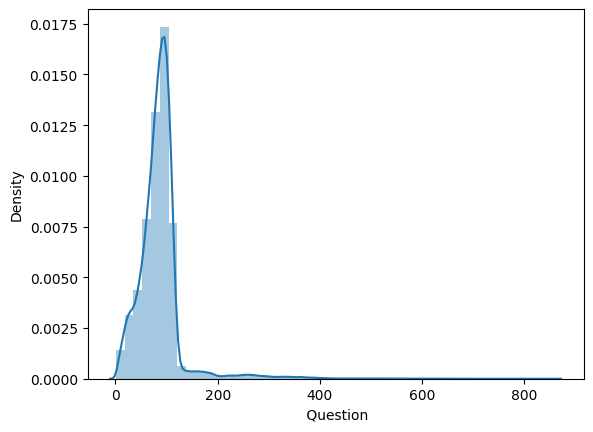

In [11]:
sns.distplot(df[" Question"].str.len())

<ipython-input-12-97be54d0513a>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[" Answer"].str.len())


<Axes: xlabel=' Answer', ylabel='Density'>

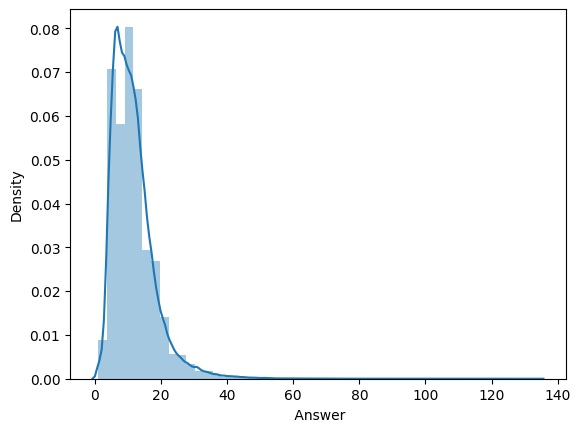

In [12]:
sns.distplot(df[" Answer"].str.len())

<Axes: xlabel=' Round', ylabel='count'>

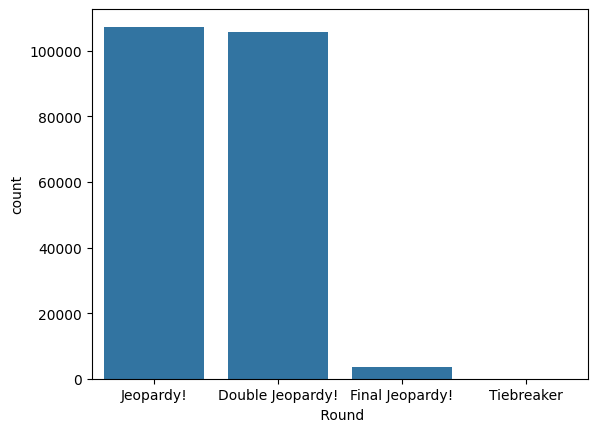

In [13]:
sns.countplot(data=df,x=' Round')

In [14]:
df[' Category'].value_counts()

,count
Category,
BEFORE & AFTER,547
SCIENCE,519
LITERATURE,496
AMERICAN HISTORY,418
POTPOURRI,401
...,...
1999 TELEVISION,1
WORDS IN PHYSICS,1
LITERATURE & MUSIC,1


In [15]:
dataset_pd=pd.DataFrame()
dataset_pd["input"]=df[" Question"]
dataset_pd["text"]=df[" Answer"]

In [16]:
model_name="togethercomputer/Llama-2-7B-32K-Instruct"

In [17]:
bnb_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.torch.bfloat16
)

In [18]:
model=AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    trust_remote_code=True,
    quantization_config=bnb_config
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
next(model.children())

LlamaModel(
  (embed_tokens): Embedding(32000, 4096, padding_idx=0)
  (layers): ModuleList(
    (0-31): 32 x LlamaDecoderLayer(
      (self_attn): LlamaSdpaAttention(
        (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
        (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
        (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
    )
  )
  (norm): LlamaRMSNorm((4096,), e

In [23]:
tokenizer=AutoTokenizer.from_pretrained(model_name)


In [24]:
tokenizer.pad_token=tokenizer.eos_token

In [25]:
model= prepare_model_for_kbit_training(model)

In [26]:
next(model.children())

LlamaModel(
  (embed_tokens): Embedding(32000, 4096, padding_idx=0)
  (layers): ModuleList(
    (0-31): 32 x LlamaDecoderLayer(
      (self_attn): LlamaSdpaAttention(
        (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
        (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
        (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
    )
  )
  (norm): LlamaRMSNorm((4096,), e

In [27]:
from peft import LoraConfig
lora_alpha=16
lora_dropout=0.2
lora_r=128
peft_config=LoraConfig(
    lora_alpha=lora_alpha,
    r=lora_r,
    lora_dropout=lora_dropout,
    bias="none",
    target_modules=[
        "q_proj",
        "v_proj",
        "k_proj",
        "o_proj"
    ]


)

In [28]:
from transformers import TrainingArguments
output_dir="./result2"
per_device_train_batch_size=4
gradient_accumulation_steps=4
optim="adamw_hf"
save_steps=10
logging_steps=10
learning_rate=0.0002
max_grad_norm=0.2
max_steps=80
warmup_ratio=0.03
lr_scheduler_type='cosine'



In [30]:
train_args=TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    evaluation_strategy='steps',
    eval_steps=10,
    lr_scheduler_type=lr_scheduler_type,


)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
dataset_pd.dropna(inplace=True)

In [32]:
dataset_hf=Dataset.from_pandas(dataset_pd)

In [33]:
dataset_hf_splited=dataset_hf.train_test_split(test_size=0.2)

In [34]:
from trl import SFTTrainer

In [35]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset_hf_splited["train"],
    eval_dataset=dataset_hf_splited["test"],
    peft_config=peft_config,
    dataset_text_field='text',
    max_seq_length=200,
    tokenizer=tokenizer,
    args=train_args
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will ove

Map:   0%|          | 0/173541 [00:00<?, ? examples/s]

Map:   0%|          | 0/43386 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aditya-freelance92 (aditya-freelance92-academy-of-technology). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


In [ ]:
model.